#### 데이터 전처리 (preprocessing)
1) df로 변환 <br>
2) feature engineering <br>
3) save preprocessed data <br>

# 필요 모듈 및 변수 설정

In [1]:
import os
import json
import h5py
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

RAW_DATA_DIR = "../input/raw_data" # 카카오에서 다운로드 받은 데이터의 디렉터리
PROCESSED_DATA_DIR = '../input/processed' # 전처리된 데이터가 저장될 디렉터리
VOCAB_DIR = os.path.join(PROCESSED_DATA_DIR, 'vocab') # 전처리에 사용될 사전 파일이 저장될

# 학습에 사용될 파일 리스트
train_file_list = [
    "train.chunk.01",
    "train.chunk.02",
    "train.chunk.03",
    "train.chunk.04",
    "train.chunk.05",
    "train.chunk.06",
    "train.chunk.07",
    "train.chunk.08",
    "train.chunk.09"
]

# 개발에 사용될 파일 리스트. 공개 리더보드 점수를 내는데 사용된다.
dev_file_list = [
    "dev.chunk.01"    
]

# 테스트에 사용될 파일 리스트. 파이널 리더보드 점수를 내는데 사용된다.
test_file_list = [
    "test.chunk.01",
    "test.chunk.02", 
]


In [2]:
# 파일명과 실제 파일이 위치한 디렉토리를 결합한다.
train_path_list = [os.path.join(RAW_DATA_DIR, fn) for fn in train_file_list]
dev_path_list = [os.path.join(RAW_DATA_DIR, fn) for fn in dev_file_list]
test_path_list = [os.path.join(RAW_DATA_DIR, fn) for fn in test_file_list]

In [3]:
train_path_list

['../input/raw_data/train.chunk.01',
 '../input/raw_data/train.chunk.02',
 '../input/raw_data/train.chunk.03',
 '../input/raw_data/train.chunk.04',
 '../input/raw_data/train.chunk.05',
 '../input/raw_data/train.chunk.06',
 '../input/raw_data/train.chunk.07',
 '../input/raw_data/train.chunk.08',
 '../input/raw_data/train.chunk.09']

In [4]:
# PROCESSED_DATA_DIR과 VOCAB_DIR를 생성한다.
# https://minimin2.tistory.com/40 (mkdir/makedirs 차이)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True) #이미 존재한다면, exception error 없이 pass
os.makedirs(VOCAB_DIR, exist_ok=True)

# 대회 데이터를 pandas.DataFrame으로 만들기. 1)

In [5]:
# path_list의 파일에서 col 변수에 해당하는 컬럼 값들을 가져온다.
def get_column_data(path_list, col):
    col_data = []
    for path in path_list:
        h = h5py.File(path, 'r')
        div = list(h.keys())[0] #seoyoon
        col_data.append(h[div][col][:]) #h구조: (h)file->(h[])group->(h[][])dataset
        h.close
    return np.concatenate(col_data) #chunk.01 - 09 col별로 list(9개 생성)로 저장 -> concat

# path_list의 파일에서 학습에 필요한 컬럼들을 DataFrame 포맷으로 반환한다.
def get_dataframe(path_list):
    col_list = ['pid', 'product', 'brand', 'maker', 'model', 'price', 
'updttm', 'bcateid', 'mcateid', 'scateid', 'dcateid']
    col_df_list = []
    for col in col_list:
        col_df_list.append(get_column_data(path_list, col=col))
    
    df = pd.DataFrame({'pid': col_df_list[0], 'product':col_df_list[1], 'brand':col_df_list[2], 'maker':col_df_list[3], 
                                      'model':col_df_list[4], 
                                      'price':col_df_list[5], 'updttm':col_df_list[6], 
                                      'bcateid':col_df_list[7], 'mcateid':col_df_list[8], 'scateid':col_df_list[9], 'dcateid':col_df_list[10]} )
    
    # 바이트 열로 인코딩 상품제목과 상품ID를 유니코드 변환한다.
    unicode_list = ['pid', 'product', 'brand', 'maker', 'model', 'updttm']
    for uni in unicode_list:
        df[uni] = df[uni].map(lambda x: x.decode('utf-8'))

    
    return df

# def get_dataframe(path_list):
#     col_list = ['pid', 'product', 'brand', 'maker', 'model', 'price', 
# 'updttm', 'bcateid', 'mcateid', 'scateid', 'dcateid']
#     col_df_dic = {}
#     for col in col_list:
#         col_df_dic[col] = get_column_data(path_list, col=col)

    
#     df = pd.DataFrame()
#     for col in col_list:
#         df[col] = col_df_dic[col]
#     print(df)

#     # 바이트 열로 인코딩 상품제목과 상품ID를 유니코드 변환한다.
#     unicode_list = ['pid', 'product', 'brand', 'maker', 'model', 'updttm']
#     for uni in unicode_list:
#         df[uni] = df[uni].map(lambda x: x.decode('utf-8'))

In [6]:
train_df_origin = get_dataframe(train_path_list)
dev_df_origin = get_dataframe(dev_path_list)
test_df_origin = get_dataframe(test_path_list)

In [7]:
train_df = train_df_origin
dev_df = dev_df_origin
test_df = test_df_origin

In [8]:
print(train_df.shape) #(8134818, 11)
print(dev_df.shape) #(507783, 11)
print(test_df.shape) #(1526523, 11)

(8134818, 11)
(507783, 11)
(1526523, 11)


In [9]:
#< h 구조확인 >
# path = '../input/raw_data/train.chunk.01'
# h = h5py.File(path, 'r')
# print(h)
# print(list(h.keys()))
# dset = h['train']
# print(dset)
# print(list(h[list(h.keys())[0]].keys()))
# dcol = dset['pid']
# print(dcol)
# print(dcol[:])

train_df.values

In [10]:
print(train_path_list)
print(train_df.head())

['../input/raw_data/train.chunk.01', '../input/raw_data/train.chunk.02', '../input/raw_data/train.chunk.03', '../input/raw_data/train.chunk.04', '../input/raw_data/train.chunk.05', '../input/raw_data/train.chunk.06', '../input/raw_data/train.chunk.07', '../input/raw_data/train.chunk.08', '../input/raw_data/train.chunk.09']
           pid                                            product  brand  \
0  O4486751463                    직소퍼즐 - 1000조각 바다거북의 여행 (PL1275)  퍼즐라이프   
1  P3307178849  [모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][...   바보사랑   
2  R4424255515                            크리비아 기모 3부 속바지 GLG4314P   크리비아   
3  F3334315393      [하프클럽/잭앤질]남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA    잭앤질   
4   N731678492                        코드프리혈당시험지50매/코드프리시험지/최장유효기간          

       maker                                       model  price  \
0  상품상세설명 참조                         퍼즐라이프 직소퍼즐 바다거북의 여행  16520   
1  MORY|해당없음  아이폰6S/6S+ tree farm101 - 다이어리케이스|아이폰6S/6S+  20370   
2                

In [11]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 500)
train_df[['product']].head(3) #[]:series, [[]]:df

,product
0,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275)
1,[모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][무료배송]
2,크리비아 기모 3부 속바지 GLG4314P


# 분석
seoyoon

### 기본내용 파악
pid :  상품 id, 각 상품의 고유 id <br>
product :  상품명 -> 정제 필요<br>
brand :  상품 브랜드명<br>
maker : 상품 메이커<br>
price : 상품 가격<br>
updttm : 상품정보 update 시간<br>
bcateid : 대 cate id<br>
mcateid : 중 cate id<br>
scateid : 소 cate id (값 없음: -1)<br> 
dcateid : 상세 cate id (값 없음: -1)<br>

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8134818 entries, 0 to 8134817
Data columns (total 11 columns):
pid        object
product    object
brand      object
maker      object
model      object
price      int32
updttm     object
bcateid    int32
mcateid    int32
scateid    int32
dcateid    int32
dtypes: int32(5), object(6)
memory usage: 527.5+ MB


In [13]:
#print('unique pid: ', train_df['pid'].unique())
print('#unique pid: ', train_df['pid'].nunique())
#전체 갯수와 같음  = unique 확인

#unique pid:  8134818


In [14]:
print('unique pid[0]: ', train_df['pid'].apply(lambda x:x[0]).unique())
print('#unique pid[0]: ', train_df['pid'].apply(lambda x:x[0]).nunique())
# 21개, 각 의미가 있을 듯

unique pid[0]:  ['O' 'P' 'R' 'F' 'N' 'J' 'V' 'Z' 'L' 'T' 'I' 'W' 'H' 'Y' 'X' 'M' 'S' 'U'
 'G' 'Q' 'K']
#unique pid[0]:  21


In [15]:
Counter(train_df['pid'].apply(lambda x:x[0]))

Counter({'O': 406288,
         'P': 406938,
         'R': 407751,
         'F': 203755,
         'N': 406448,
         'J': 406538,
         'V': 407218,
         'Z': 203381,
         'L': 407563,
         'T': 405895,
         'I': 406420,
         'W': 406491,
         'H': 407205,
         'Y': 406603,
         'X': 406788,
         'M': 406399,
         'S': 406706,
         'U': 406909,
         'G': 406245,
         'Q': 406171,
         'K': 407106})

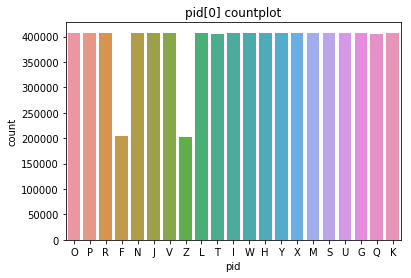

In [16]:
sns.countplot(train_df['pid'].apply(lambda x:x[0]))
plt.title('pid[0] countplot')
plt.show()
#거의 약 40만개로 비슷, F와 Z만 약 20만개

In [17]:
def print_nunique(df, col):
    print('#unique bcateid: ', df[col].nunique())
    
print_nunique(train_df, 'bcateid')
print_nunique(train_df, 'mcateid')
print_nunique(train_df, 'scateid')
print_nunique(train_df, 'dcateid')

#unique bcateid:  57
#unique bcateid:  552
#unique bcateid:  3190
#unique bcateid:  404


In [18]:
# def count_null(df):
#     for i in df.columns:
#         print(i, ' : ', sum(df[i].isnull()))

# #null check
# count_null(train_df)
# print('-'*20)
# def count_null(df):
#     for i in df.columns:
#         print(i, ' : ', df[i].isnull().count())

# #null check
# count_null(train_df)
# print('-'*20)
# def count_blank(df):
#     for i in df.columns:
#         print(i, ' : ', df[df[i]=='']['pid'].count())
        
# #blank check
# count_blank(train_df)
# print('-'*20)
# def count_blank(df):
#     cnt = 0
#     for i in df.columns:
#         for j in df[i]:
#             if "NaN" in j:
#                 cnt += 1
#         print(i, ' : ', cnt)    
        
# #blank check
# count_blank(train_df)
# print('-'*20)
# def count_semi_null(df, col):
#     cnt = 0
#     for j in df[col]:
#         if j=='-1' or j==-1:
#             cnt += 1
#     print(col, ' : ', cnt)
    
# #-1 check
# count_semi_null(train_df, 'price')
# count_semi_null(train_df, 'scateid')
# count_semi_null(train_df, 'dcateid')

# feature engineering. 2)

# 학습에 불필요한 컬럼 제거

 #### 4개의 카테고리 - 분석 용이하도록 숫자 -> 한글로 바꾸자 (by using json)

In [19]:
import json
# 카테고리 이름과 ID의 매핑 정보를 불러온다.
cate_json = json.load(open(os.path.join(RAW_DATA_DIR, 'cate1.json')))

In [20]:
# (이름, ID) 순서를 (ID, 이름)으로 바꾼 후 dictionary로 만든다.
id2nm_dic = {}
for cate in ['b', 'm', 's', 'd']:
    id2nm_dic[cate] = (dict([(cid, name) for name, cid in cate_json[cate].items()]))

In [21]:
id2nm_dic['b'], id2nm_dic['m']

({27: '가공식품/과자/초콜릿',
  21: '수납/정리/선반',
  32: '디카/캠코더/주변기기',
  8: '침구/커튼/카페트',
  39: '데스크탑/모니터/PC부품',
  54: '상품권/e쿠폰/서비스',
  56: '해외여행',
  52: '내비/블랙박스/하이패스',
  11: '홈/인테리어/가드닝',
  42: '주방가전/냉장고/전기밥솥',
  38: '영상가전/TV/홈시어터',
  53: '도서/음반/DVD',
  20: '쥬얼리/시계/액세서리',
  49: '노트북/태블릿PC',
  37: '향수/바디/헤어',
  35: '문구/사무/용지',
  29: '게임/주변기기',
  36: '거실/주방가구',
  45: '홈오피스/키즈가구',
  55: '국내여행',
  34: '자동차용품',
  44: '자전거/인라인/모터사이클',
  50: '반려동물/애완용품',
  40: '욕실/청소/세제',
  22: '유아동의류/신발/가방',
  26: '이미용/건강/욕실가전',
  51: '쌀/과일/농축수산물',
  25: '음향가전/스피커/전자사전',
  10: '건강관리/실버용품',
  14: '가방/지갑/잡화',
  13: '구기/헬스/수영/스키',
  41: '음료/생수/커피',
  28: '산업/공구/안전용품',
  23: '출산/유아용품/임부복',
  12: '등산/캠핑/낚시',
  24: '프린터/PC주변/사무기기',
  18: '스킨케어/메이크업',
  17: '신발/수제화',
  15: '계절가전/에어컨/온열기기',
  3: '휴대폰/액세서리',
  4: '침실가구',
  6: '스포츠의류/운동화/잡화',
  19: '홍삼/건강/다이어트식품',
  57: '성인',
  48: '분유/기저귀/물티슈',
  16: '주방/식기/용기',
  31: '여행',
  30: '골프클럽/의류/용품',
  47: '테마의류/잡화',
  5: '언더웨어',
  1: '악기/취미/만들기',
  9: '여성의류',
  43: '생활/제지/잡화',
  33:

In [22]:
# dictionary를 활용해 카테고리 ID에 해당하는 카테고리 이름 컬럼을 추가한다.
for cate in ['b', 'm', 's', 'd']:
    train_df[cate +'catenm'] = train_df[cate +'cateid'].map(id2nm_dic[cate])
# train_df['bcatenm'] = train_df['bcateid'].map(bid2nm)
# train_df['mcatenm'] = train_df['mcateid'].map(mid2nm)
# train_df['scatenm'] = train_df['scateid'].map(sid2nm)
# train_df['dcatenm'] = train_df['dcateid'].map(did2nm)

In [23]:
print(train_df.shape) #(8134818, 15)
train_df.head()

(8134818, 15)


,pid,product,brand,maker,model,price,updttm,bcateid,mcateid,scateid,dcateid,bcatenm,mcatenm,scatenm,dcatenm
0,O4486751463,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275),퍼즐라이프,상품상세설명 참조,퍼즐라이프 직소퍼즐 바다거북의 여행,16520,20180227091029,1,1,2,-1,악기/취미/만들기,보드게임/퍼즐,직소/퍼즐,
1,P3307178849,[모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][무료배송],바보사랑,MORY|해당없음,아이폰6S/6S+ tree farm101 - 다이어리케이스|아이폰6S/6S+,20370,20180429085019,3,3,4,-1,휴대폰/액세서리,휴대폰액세서리,아이폰액세서리,
2,R4424255515,크리비아 기모 3부 속바지 GLG4314P,크리비아,,크리비아 기모 3부 속바지 GLG4314P,-1,20180426102314,5,5,6,-1,언더웨어,보정언더웨어,속바지/속치마,
3,F3334315393,[하프클럽/잭앤질]남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,잭앤질,㈜크리스패션,[잭앤질] 남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,16280,20180422084512,7,7,8,-1,남성의류,바지,일자면바지,
4,N731678492,코드프리혈당시험지50매/코드프리시험지/최장유효기간,,기타,SD코드프리혈당시험지[50매],-1,20180424071623,10,9,11,-1,건강관리/실버용품,건강측정용품,혈당지,


## 데이터 분석

### brand 컬럼 분석

In [24]:
def get_vc_df(df, col):    
    vc_df = df[col].value_counts().reset_index()
    vc_df.columns = [col, 'count']
    vc_df['percentage'] = (vc_df['count'] / vc_df['count'].sum())*100    
    return vc_df
#value_counts: 동일요소 몇 개?
# https://kongdols-room.tistory.com/123 (set_index, reset_index)

In [25]:
def print_barplot(df, x, y):
    plt.figure(figsize=(15,8))
    sns.barplot(data=df, x=x, y=y)
    plt.title(col+'barplot')
    plt.show()

In [26]:
vc_df = get_vc_df(train_df, 'brand')
vc_df.head(10)


,brand,count,percentage
0,,3930113,48.312243
1,상품상세설명 참조,153156,1.882722
2,바보사랑,66645,0.819256
3,기타,64144,0.788512
4,상세설명참조,35795,0.440022
5,없음,33603,0.413076
6,아디다스,32292,0.396960
7,나이키,30785,0.378435
8,아트박스,28518,0.350567
9,알수없음,26768,0.329055


In [27]:
vc_df.shape

(193462, 3)

### maker 컬럼 분석

In [28]:
vc_df = get_vc_df(train_df, 'maker')
vc_df.head(10)

,maker,count,percentage
0,,2196846,27.005472
1,기타,2009828,24.706490
2,상품상세설명 참조,442299,5.437110
3,상세페이지 참조,63792,0.784185
4,상세설명참조,37899,0.465886
5,상품상세설명참조,36389,0.447324
6,아디다스,25472,0.313123
7,상세설명참조 / 상세설명참조,21873,0.268881
8,[불명],20836,0.256134
9,상품상세정보 참조,19786,0.243226


### model 컬럼 분석

In [29]:
vc_df = get_vc_df(train_df, 'model')
vc_df.head(10)

,model,count,percentage
0,,2063425,25.365349
1,기타,1606243,19.745285
2,상품상세설명 참조,295674,3.634673
3,없음,86475,1.063023
4,상세페이지 참조,35049,0.430852
5,근조화환,19642,0.241456
6,상품상세정보 참조,18727,0.230208
7,상세설명참조 / 상세설명참조,11387,0.139979
8,아트박스,10067,0.123752
9,상품 상세설명 참조,9723,0.119523


In [30]:
vc_df = get_vc_df(train_df, 'price')
vc_df.head(10)

,price,count,percentage
0,-1,5270821,64.793349
1,85500,8872,0.109062
2,10800,6522,0.080174
3,9000,6505,0.079965
4,13500,5885,0.072343
5,9900,5792,0.071200
6,94000,5083,0.062484
7,18000,4801,0.059018
8,7200,4698,0.057752
9,89300,4241,0.052134


# 최종 결정된 DataFrame

In [31]:
# 불필요한 컬럼을(brand, maker, model, price, updttm) 제거한 DataFrame 생성
train_df = train_df[['pid', 'product', 'bcateid', 'mcateid', 'scateid', 'dcateid']]
dev_df = dev_df[['pid', 'product', 'bcateid', 'mcateid', 'scateid', 'dcateid']]
test_df = test_df[['pid', 'product', 'bcateid', 'mcateid', 'scateid', 'dcateid']]

In [32]:
train_df.head()

,pid,product,bcateid,mcateid,scateid,dcateid
0,O4486751463,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275),1,1,2,-1
1,P3307178849,[모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][무료배송],3,3,4,-1
2,R4424255515,크리비아 기모 3부 속바지 GLG4314P,5,5,6,-1
3,F3334315393,[하프클럽/잭앤질]남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,7,7,8,-1
4,N731678492,코드프리혈당시험지50매/코드프리시험지/최장유효기간,10,9,11,-1


### product 상세분석 (211116)

In [33]:
train_df_product = train_df['product'].reset_index()

In [34]:
train_df_product.head(15)

,index,product
0,0,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275)
1,1,[모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][무료배송]
2,2,크리비아 기모 3부 속바지 GLG4314P
3,3,[하프클럽/잭앤질]남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA
4,4,코드프리혈당시험지50매/코드프리시험지/최장유효기간
5,5,아트박스 POOM/낭만창고 idk385-시원한 맥주 캬하~
6,6,데버스 뉴 캠핑 BBQ 글러브 DVC E1209N 캠핑 등산
7,7,엘르스포츠 여성 비키니2PCS ETFLB06NVY
8,8,[패션플러스][GEOX][GEOX] 제옥스 GH-405 블랙펄 클러치백
9,9,[아트박스 POOM/꾸밈] iz099-우럭아왜우럭


# product 칼럼 전처리 하기
**[product]<br>**

상품명 = sentence로 취급 가능 = word의 결합, but 한국어는 띄어쓰기 단위!=단어(어절을 포함하는 경우 많음/ 그치만 편의를 위해 여기서는 단어로 취급하겠다) -> 좀 더 잘 나눠보면 좋을 것 같음<br><br>
*일반 문장과 다른 특성 -> 이거 고려해서 전처리하자
1. 브랜드, 상품명, 상품코드 등 거의 명사 나열
2. 띄어쓰기, 특수문자 불규칙적
3. 특수문자를 특정 단어 강조를 위해 의미없이 반복 사용

### 센텐스피스 모델 학습|

In [35]:
import re

# 특수기호를 나열한 패턴 문자열을 컴파일하여 패턴 객체를 얻는다.
p = re.compile('[\!@#$%\^&\*\(\)\-\=\[\]\{\}\.,/\?~\+\'"|_:;><`┃]')
# 위의 패턴 문자열의 매칭되는 문자는 아래 코드를 통해서 빈공백으로 치환할 것이다.

# 문장의 특수기호 제거 함수
def remove_special_characters(sentence, lower=True):
    sentence = p.sub(' ', sentence) # 패턴 객체로 sentence 내의 특수기호를 공백문자로 치환한다.
    sentence = ' '.join(sentence.split()) # sentence 내의 두개 이상 연속된 빈공백들을 하나의 빈공백으로 만든다.
    if lower:
        sentence = sentence.lower()
    return sentence

In [36]:
# product 칼럼에 특수기호를 제거하는 함수를 적용한 결과를 반환한다.
train_df['product'] = train_df['product'].map(remove_special_characters)

train_df.head() # 특수기호가 제거된 train_df의 상단 5행만 출력
#참고: 일반 문장과는 다른 특성 -> konlp에서 사용가능한 한국어 형태소 분석기 사용 추천 x

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pid,product,bcateid,mcateid,scateid,dcateid
0,O4486751463,직소퍼즐 1000조각 바다거북의 여행 pl1275,1,1,2,-1
1,P3307178849,모리케이스 아이폰6s 6s tree farm101 다이어리케이스 바보사랑 무료배송,3,3,4,-1
2,R4424255515,크리비아 기모 3부 속바지 glg4314p,5,5,6,-1
3,F3334315393,하프클럽 잭앤질 남성 솔리드 절개라인 포인트 포켓 팬츠 31133pt002 na,7,7,8,-1
4,N731678492,코드프리혈당시험지50매 코드프리시험지 최장유효기간,10,9,11,-1


In [37]:
train_df.shape

(8134818, 6)

In [38]:
VOCAB_DIR

'../input/processed/vocab'

In [39]:
%%time
import sentencepiece as spm # sentencepiece 모듈을 가져온다.

# product 칼럼의 상품명을 product.txt 파일명으로 저장한다.
with open(os.path.join(VOCAB_DIR, 'product.txt'), 'w', encoding='utf-8') as f:
    f.write(train_df['product'].str.cat(sep='\n'))
    
# sentencepiece 모델을 학습시키는 함수이다.
def train_spm(txt_path, 
              spm_path,
              vocab_size=32000, 
              input_sentence_size=1000000):  
    # vocab_size: 사전 크기
    # input_sentence_size: 개수 만큼만 학습데이터로 사용된다.
    spm.SentencePieceTrainer.Train(
        f' --input={txt_path} --model_type=bpe'
        f' --model_prefix={spm_path} --vocab_size={vocab_size}'
        f' --input_sentence_size={input_sentence_size}'
        f' --shuffle_input_sentence=true'
    )

# product.txt 파일로 sentencepiece 모델을 학습 시킨다. 
# 학습이 완료되면 spm.model, spm.vocab 파일이 생성된다.
train_spm(txt_path=os.path.join(VOCAB_DIR, 'product.txt'), 
          spm_path=os.path.join(VOCAB_DIR, 'spm')) # spm 접두어

# 센텐스피스 모델 학습이 완료되면 product.txt는 삭제
os.remove(os.path.join(VOCAB_DIR, 'product.txt'))

# 필요한 파일이 제대로 생성됐는지 확인
for dirname, _, filenames in os.walk(VOCAB_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

CPU times: user 3.02 s, sys: 1.04 s, total: 4.06 s
Wall time: 4.06 s


../input/processed/vocab/spm.model
../input/processed/vocab/spm.vocab


### train_df 전처리

In [41]:
sp = spm.SentencePieceProcessor()
sp.Load(os.path.join(VOCAB_DIR, 'spm.model'))

True

In [42]:
sp.EncodeAsPieces('직소퍼즐 1000조각 바다거북의 여행 pl1275')

['▁직소퍼즐', '▁1000', '조각', '▁바다', '거북', '의', '▁여행', '▁pl', '12', '75']

In [43]:
# 센텐스피스 모델을 로드한다.
sp = spm.SentencePieceProcessor()
sp.Load(os.path.join(VOCAB_DIR, 'spm.model'))

# product 칼럼의 상품명을 분절한 결과를 tokenized_product 칼럼에 저장한다.
train_df['tokens'] = train_df['product'].map(lambda x: " ".join(sp.EncodeAsPieces(x)) )

train_df[['product', 'tokens']].head()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,product,tokens
0,직소퍼즐 1000조각 바다거북의 여행 pl1275,▁직소퍼즐 ▁1000 조각 ▁바다 거북 의 ▁여행 ▁pl 12 75
1,모리케이스 아이폰6s 6s tree farm101 다이어리케이스 바보사랑 무료배송,▁모리케이스 ▁아이폰 6 s ▁6 s ▁tree ▁farm 101 ▁다이어리케이스 ▁바보사랑 ▁무료배송
2,크리비아 기모 3부 속바지 glg4314p,▁크리비아 ▁기모 ▁3 부 ▁속바지 ▁gl g 43 14 p
3,하프클럽 잭앤질 남성 솔리드 절개라인 포인트 포켓 팬츠 31133pt002 na,▁하프클럽 ▁잭앤질 ▁남성 ▁솔리드 ▁절개라인 ▁포인트 ▁포켓 ▁팬츠 ▁311 33 pt 002 ▁na
4,코드프리혈당시험지50매 코드프리시험지 최장유효기간,▁코드 프리 혈 당 시험 지 50 매 ▁코드 프리 시험 지 ▁최 장 유 효 기간


###  dev_df, test_df 전처리

In [44]:
# 특수기호를 공백문자로 치환
dev_df['product'] = dev_df['product'].map(remove_special_characters) 
# product 칼럼을 분절한 뒤 token_id로 치환
dev_df['tokens'] = dev_df['product'].map(lambda x: " ".join([str(token_id) for token_id in sp.EncodeAsPieces(x)]))

# 특수기호를 공백문자로 치환
test_df['product'] = test_df['product'].map(remove_special_characters) 
# product 칼럼을 분절한 뒤 token_id로 치환
test_df['tokens'] = test_df['product'].map(lambda x: " ".join([str(token_id) for token_id in sp.EncodeAsPieces(x)]))

dev_df[['product', 'tokens']].head(), test_df[['product', 'tokens']].head()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

(                                           product  \
 0      gigabyte 미니pc gb bace 3160 램 4g hdd 500gb w   
 1    와코루 wacoal 와코루 튤레이스 홑겹 b컵브라 2칼라 nb sp dbr0156   
 2                           카렉스 블랙스2 핸들커버 실버 아반떼xd   
 3           뉴에라 mlb 도트 프린트 뉴욕 양키스 티셔츠 화이트 11502825   
 4  플러그피트니스 네오플랜 삼각아령5kg 아령 여자아령 여성아령 팔운동 여성덤벨 frog   
 
                                                               tokens  
 0         ▁gigabyte ▁미니 pc ▁gb ▁b ace ▁3 160 ▁램 ▁4 g ▁hdd ▁500 gb ▁w  
 1        ▁와코루 ▁wacoal ▁와코루 ▁튤레이스 ▁홑겹 ▁b 컵브라 ▁2 칼라 ▁nb ▁sp ▁dbr 01 56  
 2                                      ▁카렉스 ▁블랙스 2 ▁핸들커버 ▁실버 ▁아반떼 xd  
 3                  ▁뉴에라 ▁mlb ▁도트 ▁프린트 ▁뉴욕 ▁양키스 ▁티셔츠 ▁화이트 ▁1150 28 25  
 4  ▁플러그 피 트니스 ▁네오플랜 ▁삼각 아령 5 kg ▁아령 ▁여자 아령 ▁여성 아령 ▁팔 운동 ▁여성 덤벨 ▁frog  ,
                                        product  \
 0               모다까리나 nc04 목폴라레이스티셔츠 m1745t536   
 1  꿀비ids aglass 아이폰6플러스 강화유리 액정보호필름 올레포빅 0 3미리   
 2            오케이 와사비 가루 90 a 오케이 250g 와사비분 겨자분   
 3       에스까다 선글라스 ses414g 0700

# 전처리된 대회 데이터를 파일로 저장한다.

### 전처리가 완료된 train_df, dev_df, test_df를 파일로 저장한다.

In [45]:
# product, tokenized_product 칼럼을 제외한 칼럼만을 남긴다.
columns = ['pid', 'tokens',  'bcateid', 'mcateid', 'scateid', 'dcateid']
train_df = train_df[columns] 
dev_df = dev_df[columns] 
test_df = test_df[columns] 

# csv 포맷으로 저장한다.
train_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'train.csv'), index=False) 
dev_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'dev.csv'), index=False) 
test_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'test.csv'), index=False) 

### 용량이 큰 img_feat 컬럼은 별도의 hdf5 포맷의 파일로 저장

In [46]:
# image_feature는 데이터의 크기가 크므로 처리함수를 별도로 분리하였다.
def save_column_data(input_path_list, div, col, n_img_rows, output_path):
    # img_feat를 저장할 h5 파일을 생성
    h_out = h5py.File(output_path, 'w')    
    # 대회데이터의 상품개수 x 2048(img_feat 크기)로 dataset을 할당한다.
    h_out.create_dataset(col, (n_img_rows, 2048), dtype=np.float32)
    
    offset_out = 0
    
    # h5포맷의 대회데이터에서 img_feat 칼럼만 읽어서 h5포맷으로 다시 저장한다.
    for in_path in tqdm(input_path_list, desc=f'{div},{col}'):
        h_in = h5py.File(in_path, 'r')
        sz = h_in[div][col].shape[0]
        h_out[col][offset_out:offset_out+sz] = h_in[div][col][:]
        offset_out += sz
        h_in.close()
    h_out.close()


save_column_data(train_path_list, div='train', col='img_feat', n_img_rows=len(train_df), 
                 output_path=os.path.join(PROCESSED_DATA_DIR, 'train_img_feat.h5'))
save_column_data(dev_path_list, div='dev', col='img_feat', n_img_rows=len(dev_df), 
                 output_path=os.path.join(PROCESSED_DATA_DIR, 'dev_img_feat.h5'))
save_column_data(test_path_list, div='test', col='img_feat', n_img_rows=len(test_df), 
                 output_path=os.path.join(PROCESSED_DATA_DIR, 'test_img_feat.h5'))

# 파일이 제대로 생성됐는지 확인
for dirname, _, filenames in os.walk(PROCESSED_DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../input/processed/dev.csv
../input/processed/dev_img_feat.h5
../input/processed/test.csv
../input/processed/test_img_feat.h5
../input/processed/train.csv
../input/processed/train_img_feat.h5
../input/processed/vocab/spm.model
../input/processed/vocab/spm.vocab


In [ ]:
#1) brand, maker, model -> 진짜 product안에 거의 다 들어가 있는지
#2) product 심층분석

In [47]:
preprocessed_train_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'train.csv'))
preprocessed_train_df.head(20)

,pid,tokens,bcateid,mcateid,scateid,dcateid
0,O4486751463,▁직소퍼즐 ▁1000 조각 ▁바다 거북 의 ▁여행 ▁pl 12 75,1,1,2,-1
1,P3307178849,▁모리케이스 ▁아이폰 6 s ▁6 s ▁tree ▁farm 101 ▁다이어리케이스 ▁바보사랑 ▁무료배송,3,3,4,-1
2,R4424255515,▁크리비아 ▁기모 ▁3 부 ▁속바지 ▁gl g 43 14 p,5,5,6,-1
3,F3334315393,▁하프클럽 ▁잭앤질 ▁남성 ▁솔리드 ▁절개라인 ▁포인트 ▁포켓 ▁팬츠 ▁311 33 pt 002 ▁na,7,7,8,-1
4,N731678492,▁코드 프리 혈 당 시험 지 50 매 ▁코드 프리 시험 지 ▁최 장 유 효 기간,10,9,11,-1
5,J4094617432,▁아트박스 ▁poom ▁낭만창고 ▁idk 385 ▁시원한 ▁맥주 ▁캬 하,11,10,12,-1
6,V4742097320,▁데 버스 ▁뉴 ▁캠핑 ▁bbq ▁글러브 ▁dv c ▁e 1209 n ▁캠핑 ▁등산,12,11,13,-1
7,Z4154445264,▁엘르스포츠 ▁여성 ▁비키니 2 pcs ▁et fl b 06 nvy,13,12,14,-1
8,L2121928457,▁패션플러스 ▁geox ▁geox ▁제옥스 ▁gh ▁405 ▁블랙 펄 ▁클러치백,14,13,15,-1
9,J2944368118,▁아트박스 ▁poom ▁꾸밈 ▁iz 099 ▁우 럭 아 왜 우 럭,11,15,17,-1
